#**Siamese Network SNN**

Siamese Network is a type of network architecture that contains two or more identical subnetwork used for generate feature vectors for each input and compare them.

A Siamese Neural Network is a class of neural network architectures that contain two or more ***identical subnetworks***. Identical, here means, they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub-networks. It is used to find the similarity of the inputs by comparing its feature vectors, so these networks are used in many applications

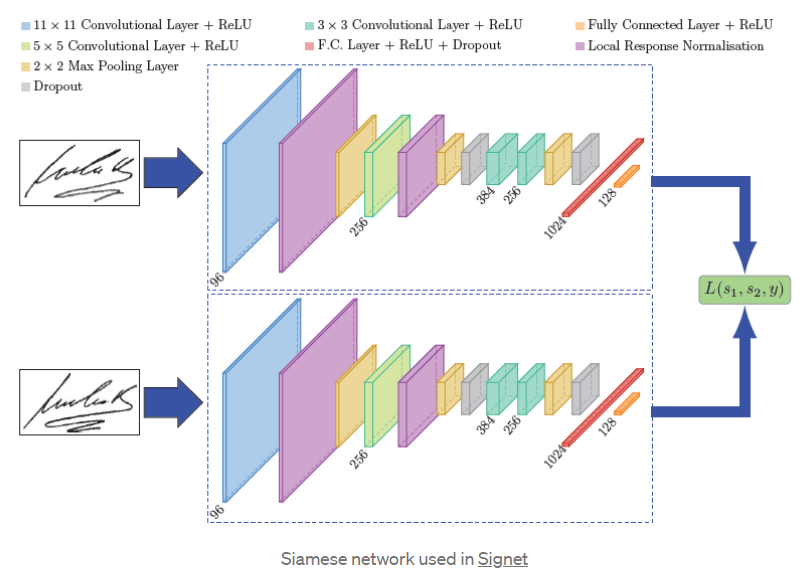

We will deal the case in whitch the SNN is to train using the Triplet Loss function.
It is based on the distance on three inputs:

- ***Anchor*** (arbitrary class of points)
- ***Positive*** (same class of the Anchor)
- ***Negative*** (different class from the Anchor)
     

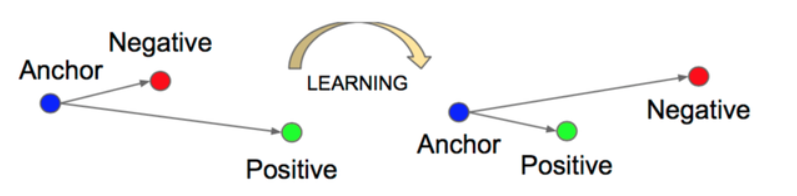

##***Pros and Cons of Siamese Networks***

The main advantages of Siamese Networks are:
- ***More Robust to class Imbalance:*** With the aid of One-shot learning, given a few images per class is sufficient for Siamese Networks to recognize those images in the future.
- ***Nice to an ensemble with the best classifier:*** Given that its learning mechanism is somewhat different from Classification, simple averaging of it with a Classifier can do much better than average 2 correlated Supervised models (e.g. RF classifier)
- ***Learning from Semantic Similarity:*** Siamese focuses on learning embeddings (in the deeper layer) that place the same classes/concepts close together. Hence, can learn *semantic similarity*.

The downsides of the Siamese Networks can be:
- ***Needs more training time than normal networks:*** Since Siamese Networks involves quadratic pairs to learn from (to see all information available) it is slower than normal classification type of learning(pointwise learning).
- ***Doesn’t output probabilities:*** Since training involves pairwise learning, it won’t output the probabilities of the prediction, but the distance from each class

##***Triplet loss*** 

\begin{eqnarray}
        \text{d(A,P) = } \|f(A) - f(P)\|, \\
        \text{d(A,N) = } \|f(A) - f(N)\|.\\
    \end{eqnarray}
And we want:
\begin{eqnarray}
        \|f(A) - f(P)\| \le \|f(A) - f(N)\|,\\
        \|f(A) - f(P)\| - \|f(A) - f(N)\| \le 0.
    \end{eqnarray}

When the input are the same, and so $d(A,P) = d(A,N)= 0$, the loss i equal to zero. This is call *trivial solution*.

To prevent trivial output, we introduce a new term call *margin*, that pushes the anchor-positive pair and the anchor-negative pair further away from each other.

\begin{eqnarray}
        \|f(A) - f(P)\| + margin - \|f(A) - f(N)\| \le 0,\\
        L(A,P,N) = \max(|f(A) - f(P)\| + margin - \|f(A) - f(N)\|, 0).
    \end{eqnarray}

The ***Cost function***:

\begin{eqnarray}
        J = \sum_{i=0}^n L(A^{(i)}, P^{(i)}, N^{(i)}).
    \end{eqnarray}

 


##***Choosing the triplets A, P, N***

During training, if A,P and N are choose randomly, $d(A,P) + margin \le d(A,N)$ is easily satisfied.

So we are interesting to choose triplets that are "hard" to train on.

\begin{eqnarray}
        d(A,P) + margin \le d(A,N), \\
        d(A,P) \sim d(A,N).
    \end{eqnarray}

In that case the learning algorithm has to try hard to keep these on the right order, so that there is at least a margin between the left and the right side. This increasing the efficiency of the learning algorithm.

Than we can apply the *Gradient Descent* to try to minimize the Cost function $J$.

##***Example***
This example uses a Siamese Network with three identical subnetworks. We will provide three images to the model, where two of them will be similar (anchor and positive samples), and the third will be unrelated (a negative example.) Our goal is for the model to learn to estimate the similarity between images.

####***Package***

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

target_shape = (200, 200)

####***Load the dataset***

We load *Totally Looks Like* dataset. It consists of two separate files:

    left.zip: contains the images that we will use as the anchor.
    right.zip: contains the images that we will use as the positive sample (an image that looks like the anchor).

*Totally Looks Like dataset by Rosenfeld et al., 2018.*

In [ ]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [ ]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From: https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
To: /content/left.zip
100% 104M/104M [00:00<00:00, 125MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
To: /content/right.zip
100% 104M/104M [00:00<00:00, 131MB/s]


####***Preparing the data***
We are going to use a tf.data pipeline to load the data and generate the triplets that we need to train the Siamese network.

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

Let's setup our data pipeline using a zipped list with an anchor, positive, and negative image filename as the source. The output of the pipeline contains the same triplet with every image loaded and preprocessed.

In [ ]:
#We need to make sure both the anchor and positive images are loaded in
#sorted order so we can match them together.

anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

#To generate the list of negative images, let's randomize the list of
#available images and concatenate them together.

rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

#Let's now split our dataset in train and validation.

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

Let's take a look at a few examples of triplets. Notice how the first two images look alike while the third one is always different. (It may happen that some anchor and positive images' relation appear inappropiate, this is due to the inherited bias of the dataset)

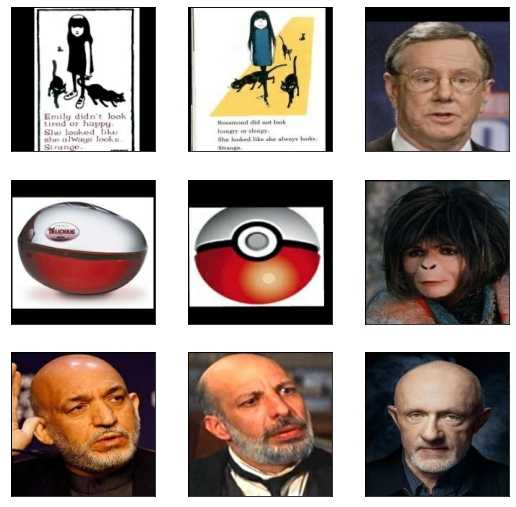

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

####***Setting up the embedding generator model***
The Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use a ***ResNet50 model*** pretrained on ImageNet and connect a few Dense layers to it so we can learn to separate these embeddings.

We will freeze the weights of all the layers of the model up until the layer ***conv5_block1_out***. This is important to avoid affecting the weights that the model has already learned. 

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94781440/94765736 [==============================] - 2s 0us/step


####***Setting up the Siamese Network model***
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        #-1 means the last axis; Since you have a rank 2 tensor, 
        #the last axis is the second axis, that is, along the rows; 
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

####***Final Model***

In [ ]:
class SiameseModel(Model):

    """
    The Siamese Network model with a custom training and testing loops.
    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.
    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)

    """
    def __init__(self, siamese_network, margin=0.2):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # compile().
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

####***Training***

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 [==============================] - 211s 1s/step - loss: 0.2380 - val_loss: 0.1572
Epoch 2/10
151/151 [==============================] - 177s 1s/step - loss: 0.1592 - val_loss: 0.1486
Epoch 3/10
151/151 [==============================] - 177s 1s/step - loss: 0.1452 - val_loss: 0.1461
Epoch 4/10
151/151 [==============================] - 177s 1s/step - loss: 0.1428 - val_loss: 0.1387
Epoch 5/10
151/151 [==============================] - 177s 1s/step - loss: 0.1385 - val_loss: 0.1300
Epoch 6/10
151/151 [==============================] - 177s 1s/step - loss: 0.1288 - val_loss: 0.1322
Epoch 7/10
151/151 [==============================] - 178s 1s/step - loss: 0.1245 - val_loss: 0.1279
Epoch 8/10
151/151 [==============================] - 178s 1s/step - loss: 0.1245 - val_loss: 0.1137
Epoch 9/10
151/151 [==============================] - 178s 1s/step - loss: 0.1213 - val_loss: 0.1168
Epoch 10/10
151/151 [==============================] - 177s 1s/step - loss: 0.1237 - val_lo

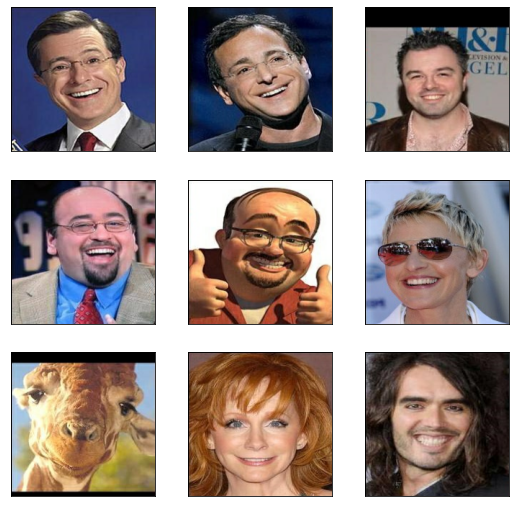

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9955846
Negative similarity 0.99463207


#***References***
[`Learning Deep Structured Semantic Models
for Web Search using Clickthrough Data, Po-Sen Huang, Xiaodong He, Jianfeng Gao, Li Deng, Alex Acero, Larry Heck`](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/cikm2013_DSSM_fullversion.pdf)

[`Image similarity estimation using a Siamese Network with a triplet loss`](https://keras.io/examples/vision/siamese_network/)

[`Deep learning Specialization, Andrew Ng`](https://www.coursera.org/specializations/deep-learning?utm_source=deeplearningai&utm_medium=institutions&utm_campaign=SocialYoutubeDLSC4W4L04
)



